In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef

In [16]:
# Load results
import pandas as pd

GROUP_NAME = "morgan_1024"
EXPERIMENT_NAME = "pcs_25"
pred = pd.read_csv(
    f"../experiments/outputs/{GROUP_NAME}/{EXPERIMENT_NAME}_DRIAMS-any_specific_results/test_set_seed0.csv"
)

df

,species,sample_id,drug,response,dataset,Predictions
0,C3A,95_059_089-lib_1681,Doxorubicin,1.0,any,0.927025
1,C3A,95_059_089-lib_1681,Doxorubicin,1.0,any,0.927025
2,C3A,95_059_089-lib_1681,Etoposide,1.0,any,0.719668
3,C3A,95_059_089-lib_1681,Gemcitabine,1.0,any,0.941483
4,C3A,95_059_089-lib_1681,Gemcitabine,1.0,any,0.941483
...,...,...,...,...,...,...
2230722,SW1417,96_122_022-lib_2608,Nelarabine,0.0,any,0.000080
2230723,SW1417,96_122_022-lib_2608,Vincristine,0.0,any,0.000164
2230724,SW1417,96_122_022-lib_2608,Venetoclax,0.0,any,0.037676
2230725,SW1417,96_122_022-lib_2608,Osimertinib,0.0,any,0.000076


In [19]:
base_dir = "/cluster/work/bewi/members/rquiles/zeroshot_amr/data"

df = pd.read_csv(os.path.join(base_dir, "combined_long_table.csv"))
splits = pd.read_csv(os.path.join(base_dir, "data_splits.csv"))

In [21]:
train_ids = splits[splits["Set"] == "train"]["sample_id"].values
test_ids = splits[splits["Set"] == "test"]["sample_id"].values

# Cell lines
all_lines = df["species"].unique()
test_lines = df[df["sample_id"].isin(test_ids)]["species"].unique()
train_lines = df[df["sample_id"].isin(train_ids)]["species"].unique()
train_only_lines = train_lines[:35]
train_random_lines = train_lines[35:40]
zeroshot_lines = [line for line in test_lines if line not in train_lines]

print(f"All lines ({len(all_lines)}): {all_lines}")
print("\n")
print(f"Train-Only lines ({len(train_only_lines)}): {train_only_lines}")
print("\n")
print(f"Test lines ({len(test_lines)}): {test_lines}")
print("\n")
print(f"Train-Random Split lines ({len(train_random_lines)}): {train_random_lines}")
print("\n")
print(f"Zeroshot lines ({len(zeroshot_lines)}): {zeroshot_lines}")

# Drugs
all_drugs = df["drug"].unique()
train_drugs = df[df["species"].isin(train_only_lines)]["drug"].unique() 
zeroshot_drugs = [drug for drug in all_drugs if drug not in train_drugs]

print(f"All Drugs: ({len(all_drugs)}): {sorted(all_drugs)}")
print("\n")
print(f"Train Drugs: ({len(train_drugs)}): {sorted(train_drugs)}")
print("\n")
print(f"Zeroshot Drugs: ({len(zeroshot_drugs)}): {sorted(zeroshot_drugs)}")

All lines (46): ['HOP62' 'A172' 'NCIH2030' 'NCISNU1' 'HCT15' 'A498' 'ASPC1' 'MIAPACA2'
 'HT29' 'SW900' 'COLO205' 'CFPAC1' 'LOXIMVI' 'LS180' 'RKO' 'J82' 'C33A'
 'NCIH1792' 'C32' 'LOVO' 'NCIH2347' 'RPMI7951' 'A549' 'NCIH23' 'SKMEL2'
 'AN3CA' 'HS578T' 'KATOIII' 'SNU423' 'HEC1A' 'BT474' 'A427' 'SHP77'
 'CHP212' 'HS766T' 'C3A' 'SW1417' 'SW48' 'PANC0327' 'NCIH1573' 'H4'
 'SW1088' 'NCIH596' 'NCIH661' 'SW1271' 'NCIH2122']


Train-Only lines (35): ['HOP62' 'A172' 'NCIH2030' 'NCISNU1' 'HCT15' 'A498' 'ASPC1' 'MIAPACA2'
 'HT29' 'SW900' 'COLO205' 'CFPAC1' 'LOXIMVI' 'LS180' 'RKO' 'J82' 'C33A'
 'NCIH1792' 'C32' 'LOVO' 'NCIH2347' 'RPMI7951' 'A549' 'NCIH23' 'SKMEL2'
 'AN3CA' 'HS578T' 'KATOIII' 'SNU423' 'HEC1A' 'BT474' 'A427' 'SHP77'
 'CHP212' 'HS766T']


Test lines (11): ['C3A' 'SW1417' 'PANC0327' 'H4' 'SW1088' 'NCIH596' 'NCIH661' 'NCIH1573'
 'SW1271' 'SW48' 'NCIH2122']


Train-Random Split lines (5): ['SW48' 'NCIH1573' 'C3A' 'PANC0327' 'SW1417']


Zeroshot lines (6): ['H4', 'SW1088', 'NCIH596', 'NCIH6

In [22]:
# Define the following sets (by sample_id)
pred["experiment"] = "_" # placeholder

# a) Random splits
mask = (pred["species"].isin(train_random_lines)) & (pred["drug"].isin(train_drugs))
pred.loc[mask, "experiment"] = "random_split"

# b) Cell line zeroshot
mask = (pred["species"].isin(zeroshot_lines)) & (pred["drug"].isin(train_drugs))
pred.loc[mask, "experiment"] = "cell_line_zeroshot"

# c) Drug zeroshot
mask = (pred["species"].isin(train_random_lines)) & (pred["drug"].isin(zeroshot_drugs))
pred.loc[mask, "experiment"] = "drug_zeroshot"

# d) Drug and Cell line zeroshot
mask = (pred["species"].isin(zeroshot_lines)) & (pred["drug"].isin(zeroshot_drugs))
pred.loc[mask, "experiment"] = "cell_line_drug_zeroshot"

assert len(pred[pred["experiment"] == "_"]) == 0

In [23]:
# Generate 4 different dataframes
random_split = pred[pred["experiment"] == "random_split"].copy()
cell_line_zeroshot = pred[pred["experiment"] == "cell_line_zeroshot"].copy()
drug_zeroshot = pred[pred["experiment"] == "drug_zeroshot"].copy()
cell_line_drug_zeroshot = pred[pred["experiment"] == "cell_line_drug_zeroshot"].copy()

## Compute metrics

In [29]:
# Define set to use
df = cell_line_zeroshot
# df = cell_line_zeroshot
# df = drug_zeroshot
# df = cell_line_drug_zeroshot

<Axes: title={'center': 'Precision-Recall Curve (AUPRC = 0.948)'}, xlabel='Recall', ylabel='Precision'>

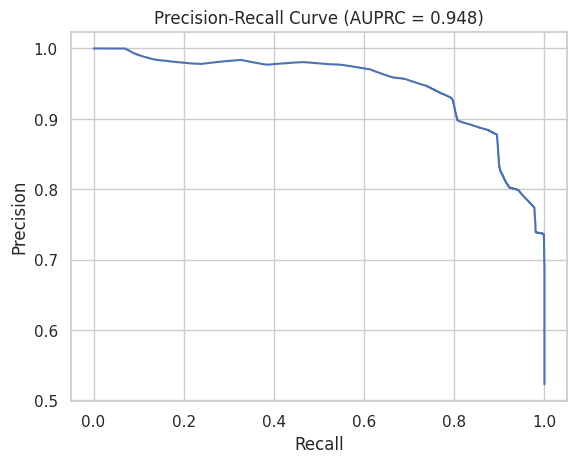

In [30]:
# AUPRC
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

df = df[["response", "Predictions"]]
y_true, y_pred = df["response"], df["Predictions"]

auprc = average_precision_score(y_true, y_pred)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

fig, ax = plt.subplots()

ax.set_title(f"Precision-Recall Curve (AUPRC = {auprc:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

sns.lineplot(x=recall, y=precision)

In [ ]:
# AUROC
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(df["response"], df["Predictions"])
auroc = roc_auc_score(y_true, y_pred)

fig, ax = plt.subplots()

ax.set_title(f"ROC (AUROC = {auroc:.3f})")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")

ax.plot([0, 1], [0, 1], "k--")

sns.lineplot(x=fpr, y=tpr)

In [ ]:
# Balanced accuracy
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(y_true, y_pred > 0.5)

print(f"Balanced accuracy: {bal_acc:.3f}")

In [ ]:
# MCC
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_true, y_pred > 0.5)

print(f"MCC: {mcc:.3f}")